In [1]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Circle
import copy

## GUI

In [2]:
def get_coordinates(column,line):
    x0 = 10
    y0 = 57

    w = 16.5
    h = 19.5
    
    incl = 10
    
    x = (column)*w + x0    
    if column<=5:
        y = line*h - incl*column + y0
    else:
        y0 = h - incl*5 + y0
        y = y0 + line*h -h - incl*(5-column)
    
    return (x,y)  

def print_board(board):
    img=mpimg.imread('board.png')
    
    ig,ax = plt.subplots(1)
    ax.set_aspect('equal')
    
    for column in range(0,len(board)):
        for line in range(0,len(board[column])):
            (x,y) = get_coordinates(column,line)
            if board[column][line] == 0:
                color = 'white'
            elif board[column][line] == 1:
                color = 'red'
            else:
                color = 'green'
            circ = Circle((x,y),5,color=color)
            ax.add_patch(circ)    
    plt.imshow(img)

## Game Logic

In [6]:
class Game:
    board = []
    player = 1
    ended = False
    waiting_removal = False
    forbidden_moves = None
    
    # Initialize the board. 0 is empty space. 1 and 2 are the players.
    def init_board(self):
        self.ended = False
        self.board = []
        self.player = 1
        self.waiting_removal = False
        self.forbidden_moves = None
        
        for column in range(11):
            if column <= 5:
                height = 5+column
            else:
                height = 15 - column 
            self.board.append([0]*height)

    def get_position(self,column,line):
        return self.board[column-1][line-1]
    
    def set_position(self,column,line,state):
        b = copy.deepcopy(self.board)
        b[column-1][line-1] = state
        return b
            
    # Put a piece on a board. State is the player (or 0 to remove a piece)
    def place_piece(self, column, line, state):
        self.board = self.set_position(column,line,state)

    # Get a fixed-size list of neighbors: [top, top-right, top-left, down, down-right, down-left]. 
    # None at any of those places where there's no neighbor
    def neighbors(self,column,line):
        l = []

        if line>1:
            l.append((column,line-1)) # up
        else:
            l.append(None)

        if (column<6 or line>1) and (column<len(self.board)):
            if column>=6:
                l.append((column+1,line-1)) # upper right
            else:
                l.append((column+1,line)) # upper right
        else:
            l.append(None)
        if (column>6 or line>1) and (column>1):
            if column>6:
                l.append((column-1,line)) # upper left
            else:
                l.append((column-1,line-1)) # upper left
        else:
            l.append(None)

        if line<len(self.board[column-1]):
            l.append((column,line+1)) # down
        else:
            l.append(None)   

        if (column<6 or line<len(self.board[column-1])) and column<len(self.board):
            if column<6:
                l.append((column+1,line+1)) # down right
            else:
                l.append((column+1,line)) # down right
        else:
            l.append(None)

        if (column>6 or line<len(self.board[column-1])) and column>1:
            if column>6:
                l.append((column-1,line+1)) # down left
            else:
                l.append((column-1,line)) # down left
        else:
            l.append(None)

        return l

    # Check if there's any possible removal (trapped pieces)
    # Returns (player,[positions]), where [positions] is a list of the two possibilities to be removed
    def can_remove(self,player):
        removals = []
        # test vertical
        for column in range(len(self.board)):
            s = ""
            l = []
            for line in range(len(self.board[column])):
                state = self.board[column][line]
                l.append((column+1,line+1))
                s += str(state)

                if "1221" in s and player==1:
                    removals.append(l[-3:-1])
                    break
                    #return (1,l[-3:-1])
                if "2112" in s and player==2:
                    removals.append(l[-3:-1])
                    break
                    #return (2,l[-3:-1])                    

        # test upward diagonals
        diags = [(1,1),(1,2),(1,3),(1,4),(1,5),(2,6),(3,7),(4,8),(5,9),(6,10)]
        for column_0, line_0 in diags:
            l = []
            s = ""
            coords = (column_0,line_0)
            prev_state = -1
            while coords!=None:
                column = coords[0]
                line = coords[1]
                state = self.board[column-1][line-1]
                l.append((column,line))
                s += str(state)
                if "1221" in s and player==1:
                    removals.append(l[-3:-1]) 
                    break
                    #return (1,l[-3:-1])
                if "2112" in s and player==2:
                    removals.append(l[-3:-1])      
                    break
                    #return (2,l[-3:-1])
                coords = self.neighbors(column,line)[1]              

        # test downward diagonals
        diags = [(6,1),(5,1),(4,1),(3,1),(2,1),(1,1),(1,2),(1,3),(1,4),(1,5)]    
        for column_0, line_0 in diags:
            l = []
            s = ""
            coords = (column_0,line_0)
            prev_state = -1
            while coords!=None:
                column = coords[0]
                line = coords[1]
                state = self.board[column-1][line-1]
                l.append((column,line))
                s += str(state)
                if "1221" in s and player==1:
                    break
                    removals.append(l[-3:-1])      
                    #return (1,l[-3:-1])
                if "2112" in s and player==2:
                    removals.append(l[-3:-1])     
                    break
                    #return (2,l[-3:-1])
                coords = self.neighbors(column,line)[4]     

        if len(removals)>0:
            removals = [item for sublist in removals for item in sublist]
            return removals
        else:
            return None

    # Check if a board is in an end-game state. Returns the winning player or None.
    def is_final_state(self):
        # test vertical
        for column in range(len(self.board)):
            prev_state = -1
            c = 0
            for line in range(len(self.board[column])):
                state = self.board[column][line]
                if state!=0:
                    if state==prev_state:
                        c += 1
                    else:
                        prev_state = state
                        c = 1
                if c==5:
                    return state

        # test upward diagonals
        diags = [(1,1),(1,2),(1,3),(1,4),(1,5),(2,6),(3,7),(4,8),(5,9),(6,10)]
        for column_0, line_0 in diags:
            c = 0
            coords = (column_0,line_0)
            prev_state = -1
            while coords!=None:
                column = coords[0]
                line = coords[1]
                state = self.board[column-1][line-1]
                if state!=0:
                    if state==prev_state:
                        c+=1
                    else:
                        prev_state = state
                        c = 1
                if c==5:
                    return state
                coords = self.neighbors(column,line)[1]              

        # test downward diagonals
        diags = [(6,1),(5,1),(4,1),(3,1),(2,1),(1,1),(1,2),(1,3),(1,4),(1,5)]    
        for column_0, line_0 in diags:
            c = 0
            coords = (column_0,line_0)
            prev_state = -1
            while coords!=None:
                column = coords[0]
                line = coords[1]
                state = self.board[column-1][line-1]
                if state!=0:
                    if state==prev_state:
                        c+=1
                    else:
                        prev_state = state
                        c = 1
                if c==5:
                    return state
                coords = self.neighbors(column,line)[4]    

        return None

    # Returns a list of positions available on a board
    def get_available_moves(self):
        l = []
        for column in range(len(self.board)):
            for line in range(len(self.board[column])):
                if self.board[column][line]==0:
                    l.append((column,line))
        return l
    
    def take_turn(self):
        if self.player==1:
            self.player=2
        else:
            self.player=1
        return self.player
    
    def make_move(self,player,column,line):
        if self.ended:
            return (-1,"Game is over")
        
        if player!=self.player:
            return (-1,"Not your turn")
        
        if column>=len(self.board) or column<0:
            return (-1,"No such column")
        if line<0 or line>len(self.board[column-1]):
            return (-1,"No such line in column %d" % column)
        
        if (column,line) == self.forbidden_moves:
            return (-1, "Position not available")
        
        if self.get_position(column,line)==0 or self.waiting_removal:
            forbidden_just_set = False
            if self.waiting_removal:
                if (column,line) in self.can_remove(self.player):
                    state = 0
                    self.waiting_removal = False
                    self.forbidden_moves = (column,line)
                    forbidden_just_set = True
                else:
                    return (-1, "Invalid removal")
            else:
                state = player
            self.board = self.set_position(column,line,state)
            if not forbidden_just_set:
                self.forbidden_moves = None
        else:
            return (-1,"Position not available")
        
        f = self.is_final_state()
        if f != None:
            self.ended = True
            return (0,"%d wins" % f)
        
        # Check for sandwiches
        possible_states = []
        
        removal_options = self.can_remove(self.player)
        if removal_options!=None:
            self.waiting_removal = True
            for option in removal_options:
                possible_states.append(self.set_position(option[0],option[1],0))
            return (player,possible_states)
        else:
            self.take_turn()
        
        for column,line in self.get_available_moves():
            if self.forbidden_moves != (column,line):
                possible_states.append(self.set_position(column,line,self.player))
        
        return (self.player,possible_states)

(-1, 'Position not available')


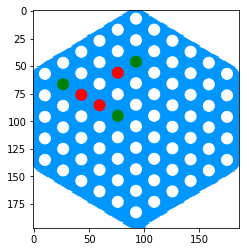

In [7]:
game = Game()
game.init_board()
game.make_move(1,4,4)
game.make_move(2,2,2)
game.make_move(1,3,3)
game.make_move(2,5,5)
game.make_move(2,3,3) # Removeu peça do adversário
print(game.make_move(1,3,3)) # Adversário tentou colocar no mesmo lugar removido
game.make_move(1,5,3) # Adversário decide colocar em outro lugar
game.make_move(2,6,3) 
game.make_move(1,3,3) # Agora adversário pode colocar no lugar previamente removido (isso NÃO dispara nova remoção)
#game.make_move(2,3,3)
print_board(game.board)

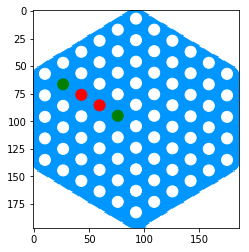

In [8]:
# Single Sandwich
game = Game()
game.init_board()
game.make_move(1,4,4)
game.make_move(2,2,2)
game.make_move(1,3,3)
game.make_move(2,5,5)
# Jogador 2 fez um sanduíche e deve remover uma das duas peças do adversário
print_board(game.board)

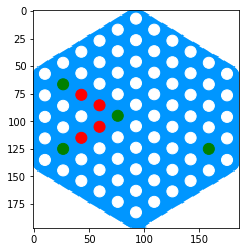

In [9]:
# Double Sandwich
game = Game()
game.init_board()
game.make_move(1,4,4)
game.make_move(2,2,2)
game.make_move(1,3,3)
game.make_move(2,10,5)
game.make_move(1,4,5)
game.make_move(2,2,5)
game.make_move(1,3,5)
game.make_move(2,5,5) 
# Jogador 2 pode fez um sanduiche duplo e deve escolher uma das quatro peças do jogador 1
print_board(game.board)